## Objective of this visualization section

The goal of this section is to **understand the merged dataset** after integrating subjective and objective assessments, and to verify that the data is suitable for downstream modeling.

Specifically:
- Check the **distribution of NHY stages** and remove invalid/out-of-scope values (e.g., `NHY = 101.0`)
- Group NHY into **three clinically meaningful severity categories**: Healthy (0), Mild-PD (1–2), and Severe-PD (3–5)
- Visualize **sample balance** across groups
- Explore whether the integrated features show **natural separation or clustering** by severity using **PCA** and **t-SNE** embeddings
- Use color-coded plots to make severity patterns easy to interpret and communicate 

## Setup

In [2]:
# ------------------------------
# Visualization: Libraries + plot defaults
# ------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Consistent look for plots (good for reports/interviews)
sns.set_theme(style="whitegrid", context="notebook")

# Make plots readable by default
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

def to_numeric_series(df: pd.DataFrame, col: str) -> pd.Series:
    """Return a numeric Series (coerces non-numeric to NaN) and drops missing."""
    return pd.to_numeric(df[col], errors="coerce").dropna()

## Load subjective and objective feature tables

In this section, I load two prepared feature tables:

- **Subjective features** (questionnaires / self-reported measures)
- **Objective features** (clinician-assessed or performance-based measures)

Both files are expected to contain a common visit-level key: `PATNO_EVENT`.

In [10]:
# ------------------------------
# Load subjective + objective feature files, then merge on PATNO_EVENT
# ------------------------------

PATH_SUBJECTIVE = "data/Subjectives_Features_All_Visit_not_normalized_nan_removed.csv"
PATH_OBJECTIVE  = "data/Oubjectives_Features_All_Visit_not_normalized_SFT1_nan_removed.csv"

def read_features_csv(path: str) -> pd.DataFrame:
    """
    Read a CSV and drop common artifact index columns safely.
    """
    df = pd.read_csv(path)

    # Drop accidental index columns if they exist
    drop_candidates = ["Unnamed: 0", "index"]
    df = df.drop(columns=[c for c in drop_candidates if c in df.columns], errors="ignore")

    # Basic key check
    if "PATNO_EVENT" not in df.columns:
        raise KeyError(f"'PATNO_EVENT' not found in {path}")

    return df

df_subjective = read_features_csv(PATH_SUBJECTIVE)
df_objective  = read_features_csv(PATH_OBJECTIVE)

print("Subjective shape:", df_subjective.shape, "| unique keys:", df_subjective["PATNO_EVENT"].nunique())
print("Objective  shape:", df_objective.shape,  "| unique keys:", df_objective["PATNO_EVENT"].nunique())

# Merge (inner join keeps only visits present in both)
df_combined = pd.merge(
    df_subjective,
    df_objective,
    on="PATNO_EVENT",
    how="inner",
    validate="one_to_one"   # ensures both files have unique PATNO_EVENT
)

print("Combined  shape:", df_combined.shape, "| unique keys:", df_combined["PATNO_EVENT"].nunique())
df_combined.head()

Subjective shape: (17799, 143) | unique keys: 17799
Objective  shape: (16073, 69) | unique keys: 16073
Combined  shape: (15624, 211) | unique keys: 15624


,PATNO_EVENT,NP1CNST,NP1FATG,NP1LTHD,NP1PAIN,NP1SLPD,NP1SLPN,NP1URIN,NP2DRES,NP2EAT,...,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NHY
0,3000_BL,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3000_V04,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3000_V06,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3000_V08,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000_V10,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Inspect and filter NHY values

Here I inspect the distribution of `NHY` values (unique categories and sample counts) using a bar plot and value counts.  
After confirming the distribution, I remove rows where `NHY == 101.0`, since these values represent an invalid or out-of-scope category for the analysis.

Combined shape (before): (15624, 211)

NHY value counts (before):
NHY
0.0      7689
1.0      1803
2.0      5561
3.0       451
4.0        84
5.0        18
101.0      18
Name: count, dtype: int64


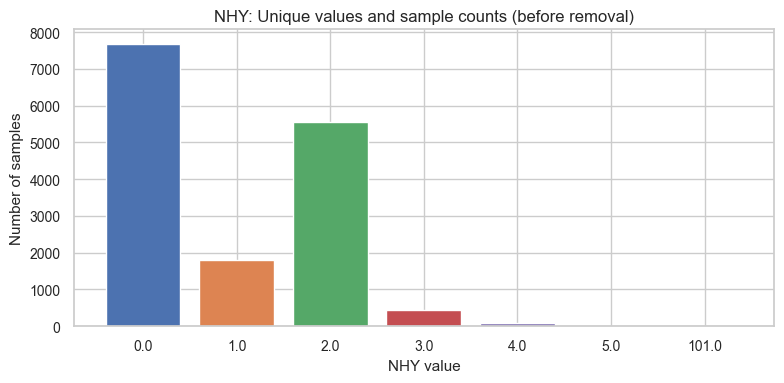


Combined shape (after removing NHY==101.0): (15606, 211)

NHY value counts (after):
NHY
0.0    7689
1.0    1803
2.0    5561
3.0     451
4.0      84
5.0      18
Name: count, dtype: int64


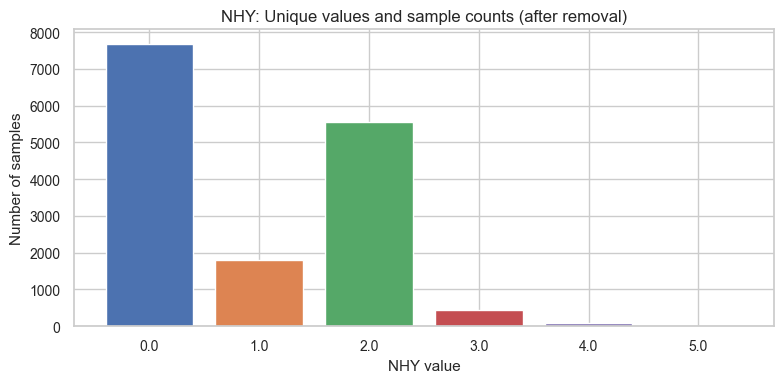

In [11]:
# ------------------------------
# Inspect and filter NHY with colored bars per NHY value
# ------------------------------

TARGET_COL = "NHY"
REMOVE_VALUE = 101.0

if TARGET_COL not in df_combined.columns:
    raise KeyError(f"Column '{TARGET_COL}' not found in df_combined.")

print("Combined shape (before):", df_combined.shape)

# Value counts
n_counts_before = df_combined[TARGET_COL].value_counts(dropna=False).sort_index()
print("\nNHY value counts (before):")
print(n_counts_before)

# Bar plot with different color for each NHY value
labels_before = n_counts_before.index.astype(str).tolist()
colors_before = sns.color_palette("deep", n_colors=len(n_counts_before))

plt.figure(figsize=(8, 4))
plt.bar(labels_before, n_counts_before.values, color=colors_before)
plt.title("NHY: Unique values and sample counts (before removal)")
plt.xlabel("NHY value")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

# Remove NHY == 101.0
df_combined = df_combined[df_combined[TARGET_COL] != REMOVE_VALUE].copy()

print("\nCombined shape (after removing NHY==101.0):", df_combined.shape)

n_counts_after = df_combined[TARGET_COL].value_counts(dropna=False).sort_index()
print("\nNHY value counts (after):")
print(n_counts_after)

# Plot again after removal (colored bars)
labels_after = n_counts_after.index.astype(str).tolist()
colors_after = sns.color_palette("deep", n_colors=len(n_counts_after))

plt.figure(figsize=(8, 4))
plt.bar(labels_after, n_counts_after.values, color=colors_after)
plt.title("NHY: Unique values and sample counts (after removal)")
plt.xlabel("NHY value")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

## Create NHY severity groups (3-class)

I convert the original `NHY` scale into three clinically meaningful groups:

- **Healthy:** NHY = 0  
- **Mild-PD:** NHY = 1–2  
- **Severe-PD:** NHY = 3–5  

This creates a `NHY_3class` label that is easier to use for visualization, clustering, and downstream modeling.

In [12]:
# ------------------------------
# Create 3-class severity label from NHY
#   0   -> Healthy
#   1,2 -> Mild-PD
#   3-5 -> Severe-PD
# ------------------------------

df = df_combined.copy()

# Ensure NHY is numeric
df["NHY"] = pd.to_numeric(df["NHY"], errors="coerce")

def map_nhy_to_3class(nhy):
    if pd.isna(nhy):
        return np.nan
    if nhy == 0:
        return 0  # Healthy
    if nhy in [1, 2]:
        return 1  # Mild-PD
    if nhy in [3, 4, 5]:
        return 2  # Severe-PD
    return np.nan  # any unexpected value

df["NHY_3class"] = df["NHY"].apply(map_nhy_to_3class)

# Optional: human-readable label
class_names = {0: "Healthy (0)", 1: "Mild-PD (1-2)", 2: "Severe-PD (3-5)"}
df["NHY_3class_label"] = df["NHY_3class"].map(class_names)

# Sanity check
print("NHY_3class value counts:")
print(df["NHY_3class"].value_counts(dropna=False).sort_index())

# Crosstab to confirm mapping
pd.crosstab(df["NHY"], df["NHY_3class"], dropna=False)

NHY_3class value counts:
NHY_3class
0    7689
1    7364
2     553
Name: count, dtype: int64


NHY_3class,0,1,2
NHY,,,
0.0,7689,0,0
1.0,0,1803,0
2.0,0,5561,0
3.0,0,0,451
4.0,0,0,84
5.0,0,0,18


## t-SNE visualization colored by NHY stage (0–5)

In this plot, I visualize the 2D **t-SNE embedding** and color each sample by its original **NHY stage (0–5)** using a custom discrete colormap.

- I define a fixed color for each NHY stage (0 to 5) to ensure consistent interpretation across plots.
- I create an **ordered color list** and build a `ListedColormap`, so that each integer stage maps to the intended color.
- The scatter plot uses this colormap, and a colorbar is added to show the stage-to-color mapping.

This view helps check whether severity stages form meaningful patterns or gradients in the embedded feature space.

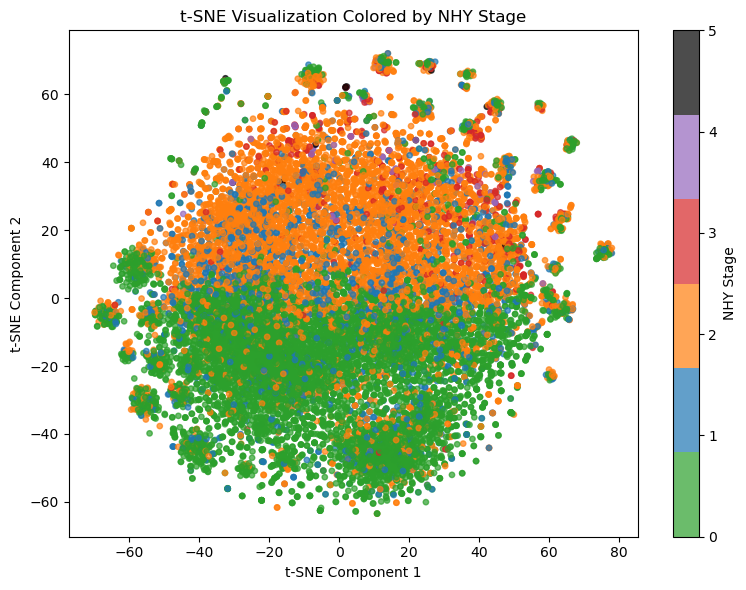

In [49]:
import matplotlib.colors as mcolors

nhy_colors = {
    0: '#2ca02c',  # green
    1: '#1f77b4',  # blue
    2: '#ff7f0e',  # orange
    3: '#d62728',  # red
    4: '#9467bd',  # purple
    5: '#000000'   # black
}
#'#2ca02c', '#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b'
# Create ordered color list (important!)
color_list = [nhy_colors[i] for i in sorted(nhy_colors.keys())]

nhy_cmap = mcolors.ListedColormap(color_list)

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=df['NHY'],
    cmap=nhy_cmap,
    alpha=0.7,
    s=15
)

cbar = plt.colorbar(scatter, ticks=range(0, 6))
cbar.set_label('NHY Stage')

plt.title('t-SNE Visualization Colored by NHY Stage')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()



## Sample distribution by NHY severity group (3-class)

This bar plot summarizes the **class balance** after grouping NHY into three clinically meaningful categories:

- **Healthy (0)** — colored **green**
- **Mild-PD (1–2)** — colored **blue**
- **Severe-PD (3–5)** — colored **red**

I enforce a consistent category order, plot the number of samples in each group, and annotate each bar with the **exact count** to make the class distribution easy to interpret at a glance.

/var/folders/j8/xcllb4g96fzf8q6mkjmc60lw0000gp/T/ipykernel_27559/139594004.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


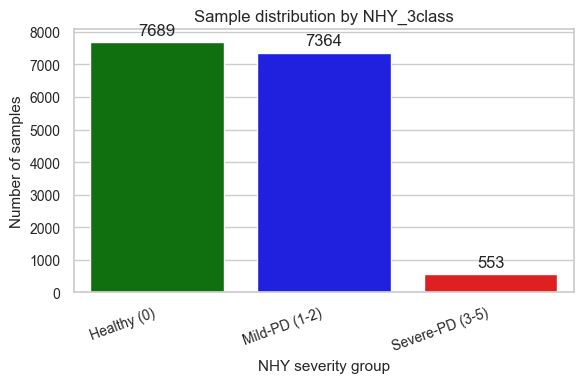

In [15]:
# Bar plot: NHY_3class distribution with custom colors + count labels on top

# Ensure consistent order
order = ["Healthy (0)", "Mild-PD (1-2)", "Severe-PD (3-5)"]

counts = df["NHY_3class_label"].value_counts(dropna=False).reindex(order)

# Color mapping you requested
palette = {
    "Healthy (0)": "green",
    "Mild-PD (1-2)": "blue",
    "Severe-PD (3-5)": "red",
}

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=[palette.get(lbl, "gray") for lbl in counts.index]
)

plt.title("Sample distribution by NHY_3class")
plt.xlabel("NHY severity group")
plt.ylabel("Number of samples")
plt.xticks(rotation=20, ha="right")

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()

## t-SNE visualization of severity groups (NHY_3class)

To explore whether the integrated feature space naturally separates clinical severity groups, I generate a 2D **t-SNE embedding** using the merged numeric features.  
Samples are colored by `NHY_3class`:

- Green: **NHY = 0** (Healthy)  
- Blue: **NHY = 1–2** (Mild-PD)  
- Red: **NHY = 3–5** (Severe-PD)  

Before embedding, I apply median imputation for missing values and standard scaling.

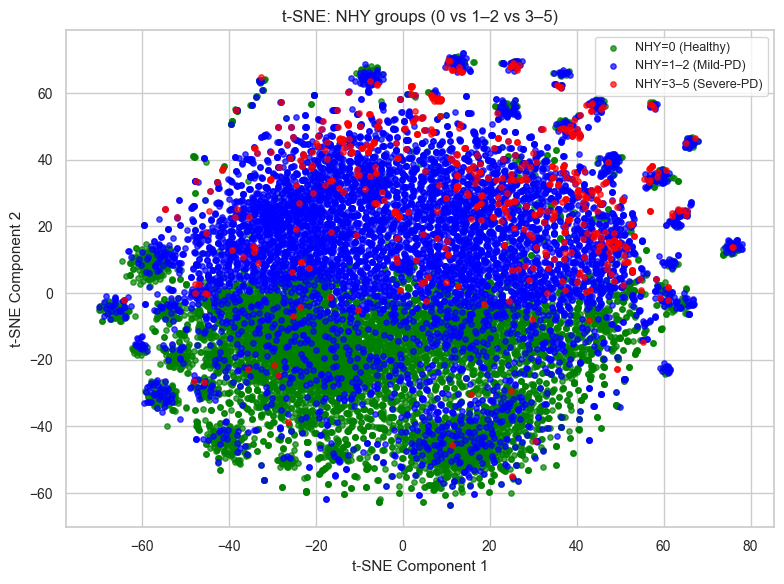

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# ------------------------------
# t-SNE visualization (NHY_3class)
# ------------------------------

df["NHY_3class"] = df["NHY"].apply(map_nhy_to_3class)

# Keep only valid classes
df3 = df.dropna(subset=["NHY_3class"]).copy()
df3["NHY_3class"] = df3["NHY_3class"].astype(int)

# Human-readable labels
class_labels = {0: "NHY=0 (Healthy)", 1: "NHY=1–2 (Mild-PD)", 2: "NHY=3–5 (Severe-PD)"}
df3["NHY_3class_label"] = df3["NHY_3class"].map(class_labels)

# Features and labels
drop_cols = ["PATNO_EVENT", "NHY", "NHY_3class", "NHY_3class_label"]
X = df3.drop(columns=[c for c in drop_cols if c in df3.columns], errors="ignore")
y = df3["NHY_3class"]

# Keep numeric only
X = X.select_dtypes(include=[np.number]).copy()

# Impute missing values (median is robust)
X = X.fillna(X.median(numeric_only=True))

# Scale features (important for t-SNE)
X_scaled = StandardScaler().fit_transform(X)

# t-SNE (note: TSNE can be slow on large datasets)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,   # newer sklearn uses max_iter instead of n_iter
    init="pca",
    random_state=42
)

Z = tsne.fit_transform(X_scaled)

# Plot
colors = {0: "green", 1: "blue", 2: "red"}

plt.figure(figsize=(8, 6))
for cls in [0, 1, 2]:
    mask = (y.values == cls)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=15,
        alpha=0.7,
        label=class_labels[cls],
        c=colors[cls]
    )

plt.title("t-SNE: NHY groups (0 vs 1–2 vs 3–5)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()

## PCA visualization (2D) for severity group separation

To assess whether the integrated feature space contains a low-dimensional structure that separates clinical severity groups, I apply **Principal Component Analysis (PCA)** to the standardized feature matrix (`X_scaled`) and project samples into **two dimensions (PC1 and PC2)**.

- PCA is a **linear** dimensionality reduction method that captures directions of maximum variance.
- I plot the 2D PCA embedding and color points by `NHY_3class`:
  - **Green:** NHY = 0 (Healthy)
  - **Blue:** NHY = 1–2 (Mild-PD)
  - **Red:** NHY = 3–5 (Severe-PD)

The axis labels include the **percentage of variance explained** by PC1 and PC2. I also print the explained variance ratios to quantify how much of the original information is preserved in the 2D projection.

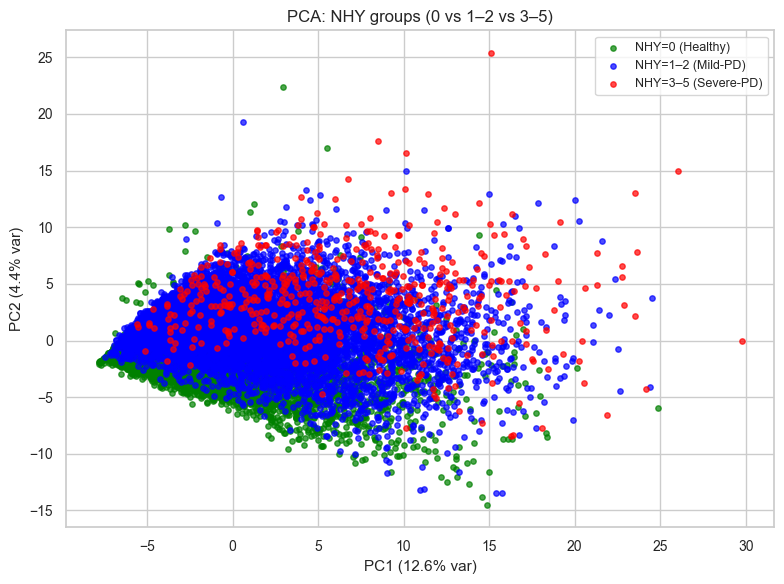

Explained variance ratio: [0.12630488 0.04376215]
Total variance (PC1+PC2): 0.17006702215413028


In [22]:
# ------------------------------
# PCA visualization (2D)
# ------------------------------

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cls in [0, 1, 2]:
    mask = (y.values == cls)
    plt.scatter(
        Z_pca[mask, 0],
        Z_pca[mask, 1],
        s=15,
        alpha=0.7,
        label=class_labels[cls],
        c=colors[cls]
    )

plt.title("PCA: NHY groups (0 vs 1–2 vs 3–5)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance (PC1+PC2):", pca.explained_variance_ratio_.sum())